### Import Dog Dataset

Import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
#import libraries
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
import pandas as pd  #we'll use this to create df's to get the count of dog breeds
import matplotlib.pyplot as plt  #visualize the img counts, by class, shapes of images, and preview images
from glob import glob



Using TensorFlow backend.


### Create a function to load images

The function will load the images and provide the counts of:
1. Total dog categories
2. Total dog images
3. Training dog images
4. Testing dog images 
4. Validation dog images 

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d test dog images.'% len(test_files))
print('There are %d validation dog images.' % len(valid_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 836 test dog images.
There are 835 validation dog images.


### Explore the dataset

Next we will explore the data to see:
1. How many images there are for each breed.  
    a. This will help us determine if we need to augment the classes to decrease the variability between classes.
2. Height and Width of the images.
    a. This will help us see if the images are around the same size or vary widely.  

In [3]:
df = []

def class_graph(loc):
    breedNames = []
    breedFiles = []
    dogDf = pd.DataFrame()

    for  folder in sorted(glob("dogImages/"+loc+"/*/")):
        breedNames.append(folder[19:-1])
        breedFiles.append(len(folder))    
    dogDf['Breed_Names'] = breedNames
    dogDf['Num_of_Files'] = breedFiles
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.bar(breedNames,breedFiles)
    plt.show()
    df.append(dogDf)
    dogDf.to_csv('exploration/'+loc+'.csv')
    return dogDf

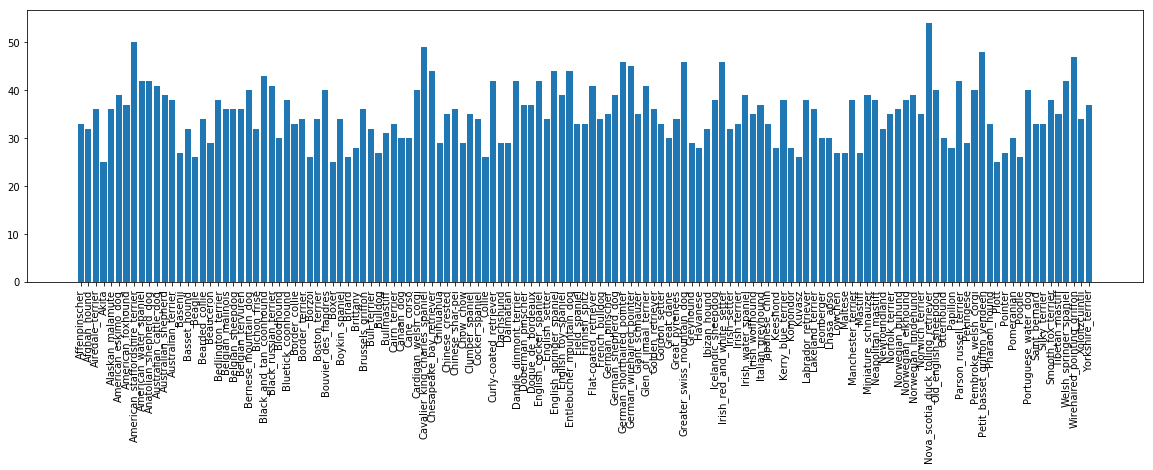

FileNotFoundError: [Errno 2] No such file or directory: 'exploration/test.csv'

In [4]:
class_graph('test')

We're going to put the results in a df so we can export and see the classes we may need to get more images for

In [6]:
breedDf = df[0]
breedDf.head()

,Breed_Names,Num_of_Files
0,Affenpinscher,33
1,Afghan_hound,32
2,Airedale_terrier,36
3,Akita,25
4,Alaskan_malamute,36


The df shows us the number of test images for each class, which there isn't much variance between them.  This would indicate that we can use the accuracy metric since the classes are close to balanced.

In [7]:
import cv2  #use features within OpenCV

imgHeight=[]
imgWidth=[]
for i in range(0,len(train_files)):
    img = cv2.imread(train_files[i])
    height, width, channels = img.shape 
    imgHeight.append(height)
    imgWidth.append(width)

ModuleNotFoundError: No module named 'cv2'

Text(0, 0.5, 'Image Width')

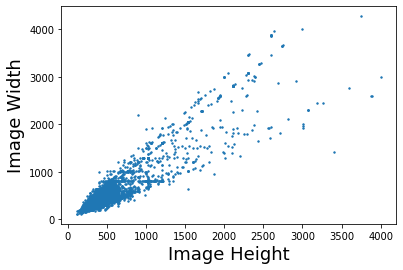

In [71]:
#create a scatterplot to look at the overall heigh/weight spread of the data. 
plt.scatter(imgHeight,imgWidth, s=2)
plt.xlabel('Image Height', fontsize=18)
plt.ylabel('Image Width', fontsize=18)

The scatterplot shows that most of the images are around 1000 x 1000 pixles.

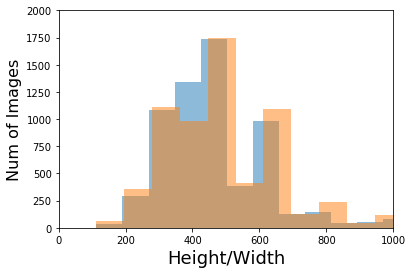

In [72]:
plt.hist(imgHeight,bins = 50, alpha=0.5)
plt.hist(imgWidth,bins = 50,alpha=0.5)
plt.axis([0,1000,0,2000])
plt.xlabel('Height/Width', fontsize=18)
plt.ylabel('Num of Images', fontsize=16)
plt.show()

In [73]:
import random #allows us to randomize the dataset
random.seed(8675425)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


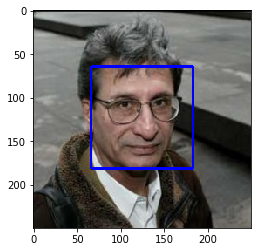

In [74]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[5])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

# Function: Human Face Detector

This function will returns `True` if a human face is detected in an image and `False` otherwise.  This function takes a string-valued file path to an image as input and appears in the code block below.

In [75]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

# Assess the Human Face Detector Accuracy

In [76]:
#create a sub-set of the image files for human and dog breeds
human_files_short = human_files[:150]
dog_files_short = train_files[:150]

#This will let us test the accuracy of the face detector finding humans vs. dogs.  

#human face detection in human_files_short
fd_human = [face_detector(fname) for fname in human_files_short]
percentage_human = 100*sum([f>0 for f in fd_human])/len(fd_human)
print(percentage_human,'% of the first 150 images in human_files had a human face detected in them.')

#dog face detection in dog_files_short
fd_dog = [face_detector(fname) for fname in dog_files_short]
percentage_dog = 100*sum([f>0 for f in fd_dog])/len(fd_dog)
print(percentage_dog,'% of the first 150 images in dog_files had a human face detected in them.')

98.0 % of the first 150 images in human_files had a human face detected in them.
14.0 % of the first 150 images in dog_files had a human face detected in them.


# Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  

First we download the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [77]:
from keras.applications.resnet50 import ResNet50   #allows us to access the pre-trained dog detector from ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

# Preprocess the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [78]:
from keras.preprocessing import image  #allows Keras to view/process images                
from tqdm import tqdm  #logs the looping progress

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [79]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
#     print(image.shape)
    return np.argmax(ResNet50_model.predict(img))

# Write the Dog Detector

We will use [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) categories and limit them to only dog breeds, which are dictionary keys 151-268.  To check and see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only need to check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

In [80]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

# Asses the Dog Detector

Use the code cell below to test the performance of the `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [81]:
#This will let us test the accuracy of the dog detector finding humans vs. dogs 
#using the images in human_files_short and dog_files_short.

dd_human = [dog_detector(fname) for fname in human_files_short]
dpercentage_human = 100*sum([f>0 for f in dd_human])/len(dd_human)
print(dpercentage_human,'% of the first 150 images in human_files had a dog detected in them.')
    
dd_dog = [dog_detector(fname) for fname in dog_files_short]
dpercentage_dog = 100*sum([f>0 for f in dd_dog])/len(dd_dog)
print(dpercentage_dog,'% of the first 150 images in dog_files had a dog detected in them.')

2.0 % of the first 150 images in human_files had a dog detected in them.
98.66666666666667 % of the first 150 images in dog_files had a dog detected in them.


This indicates that the dog detector is highly accurate at identifying a dog vs. human

## Use CNN to Classify Dog Breeds 

We used the bottleneck features from the Xception pre-trained model.  
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features


### Obtain Bottleneck Features

Below we extracted the bottleneck features corresponding to the train, test, and validation sets.

In [82]:
# Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

In [83]:
# Define the architecture.  There are 133 different breeds, which is used for the dense layer 
from keras.layers import GlobalAveragePooling2D  #add global average pooling 2D
from keras.layers import Dense  #add the dense layer
from keras.models import Sequential  #add the sequential function

Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=(train_Xception.shape[1:])))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


##  Compile the Model

Here is an article about how to choose Last Layer activation and loss function [website](https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/).

In [84]:
# Compile the model.

Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [85]:
# Train the model
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 32s - loss: 5.00 - ETA: 13s - loss: 5.08 - ETA: 10s - loss: 4.84 - ETA: 9s - loss: 4.7171 - ETA: 8s - loss: 4.471 - ETA: 8s - loss: 4.296 - ETA: 7s - loss: 4.203 - ETA: 7s - loss: 4.068 - ETA: 7s - loss: 3.912 - ETA: 7s - loss: 3.769 - ETA: 7s - loss: 3.585 - ETA: 7s - loss: 3.438 - ETA: 7s - loss: 3.294 - ETA: 6s - loss: 3.187 - ETA: 6s - loss: 3.087 - ETA: 6s - loss: 2.990 - ETA: 6s - loss: 2.891 - ETA: 6s - loss: 2.823 - ETA: 6s - loss: 2.748 - ETA: 6s - loss: 2.675 - ETA: 6s - loss: 2.603 - ETA: 6s - loss: 2.534 - ETA: 6s - loss: 2.471 - ETA: 6s - loss: 2.410 - ETA: 5s - loss: 2.352 - ETA: 5s - loss: 2.301 - ETA: 5s - loss: 2.260 - ETA: 5s - loss: 2.222 - ETA: 5s - loss: 2.177 - ETA: 5s - loss: 2.142 - ETA: 5s - loss: 2.103 - ETA: 5s - loss: 2.061 - ETA: 5s - loss: 2.028 - ETA: 5s - loss: 1.991 - ETA: 5s - loss: 1.958 - ETA: 5s - loss: 1.921 - ETA: 5s - loss: 1.889 - ETA: 4s 

6680/6680 [==============================] - ETA: 6s - loss: 0.229 - ETA: 7s - loss: 0.123 - ETA: 7s - loss: 0.143 - ETA: 7s - loss: 0.142 - ETA: 7s - loss: 0.172 - ETA: 7s - loss: 0.178 - ETA: 6s - loss: 0.189 - ETA: 6s - loss: 0.193 - ETA: 6s - loss: 0.194 - ETA: 6s - loss: 0.235 - ETA: 6s - loss: 0.241 - ETA: 6s - loss: 0.234 - ETA: 6s - loss: 0.222 - ETA: 6s - loss: 0.224 - ETA: 6s - loss: 0.225 - ETA: 6s - loss: 0.226 - ETA: 6s - loss: 0.242 - ETA: 6s - loss: 0.236 - ETA: 5s - loss: 0.236 - ETA: 5s - loss: 0.245 - ETA: 6s - loss: 0.242 - ETA: 5s - loss: 0.246 - ETA: 5s - loss: 0.241 - ETA: 5s - loss: 0.241 - ETA: 5s - loss: 0.237 - ETA: 5s - loss: 0.233 - ETA: 5s - loss: 0.234 - ETA: 5s - loss: 0.232 - ETA: 5s - loss: 0.228 - ETA: 5s - loss: 0.227 - ETA: 5s - loss: 0.224 - ETA: 5s - loss: 0.219 - ETA: 5s - loss: 0.223 - ETA: 5s - loss: 0.219 - ETA: 5s - loss: 0.216 - ETA: 5s - loss: 0.219 - ETA: 4s - loss: 0.218 - ETA: 4s - loss: 0.218 - ETA: 4s - loss: 0.221 - ETA: 4s - loss: 0.2

6680/6680 [==============================] - ETA: 9s - loss: 0.050 - ETA: 9s - loss: 0.095 - ETA: 9s - loss: 0.073 - ETA: 9s - loss: 0.087 - ETA: 9s - loss: 0.135 - ETA: 9s - loss: 0.160 - ETA: 8s - loss: 0.158 - ETA: 8s - loss: 0.198 - ETA: 8s - loss: 0.180 - ETA: 7s - loss: 0.161 - ETA: 7s - loss: 0.147 - ETA: 7s - loss: 0.137 - ETA: 7s - loss: 0.132 - ETA: 7s - loss: 0.136 - ETA: 6s - loss: 0.137 - ETA: 6s - loss: 0.131 - ETA: 6s - loss: 0.133 - ETA: 6s - loss: 0.134 - ETA: 6s - loss: 0.128 - ETA: 6s - loss: 0.136 - ETA: 6s - loss: 0.135 - ETA: 6s - loss: 0.146 - ETA: 6s - loss: 0.144 - ETA: 6s - loss: 0.141 - ETA: 5s - loss: 0.144 - ETA: 5s - loss: 0.143 - ETA: 5s - loss: 0.141 - ETA: 5s - loss: 0.144 - ETA: 5s - loss: 0.142 - ETA: 5s - loss: 0.141 - ETA: 5s - loss: 0.142 - ETA: 5s - loss: 0.145 - ETA: 5s - loss: 0.143 - ETA: 5s - loss: 0.143 - ETA: 5s - loss: 0.143 - ETA: 5s - loss: 0.145 - ETA: 5s - loss: 0.144 - ETA: 5s - loss: 0.142 - ETA: 5s - loss: 0.144 - ETA: 4s - loss: 0.1

6680/6680 [==============================] - ETA: 6s - loss: 0.261 - ETA: 6s - loss: 0.111 - ETA: 6s - loss: 0.134 - ETA: 7s - loss: 0.139 - ETA: 6s - loss: 0.128 - ETA: 7s - loss: 0.119 - ETA: 6s - loss: 0.130 - ETA: 6s - loss: 0.123 - ETA: 6s - loss: 0.123 - ETA: 6s - loss: 0.111 - ETA: 6s - loss: 0.139 - ETA: 6s - loss: 0.132 - ETA: 6s - loss: 0.125 - ETA: 6s - loss: 0.124 - ETA: 6s - loss: 0.136 - ETA: 6s - loss: 0.135 - ETA: 6s - loss: 0.135 - ETA: 6s - loss: 0.128 - ETA: 6s - loss: 0.124 - ETA: 6s - loss: 0.121 - ETA: 6s - loss: 0.121 - ETA: 5s - loss: 0.116 - ETA: 5s - loss: 0.114 - ETA: 5s - loss: 0.112 - ETA: 5s - loss: 0.116 - ETA: 5s - loss: 0.115 - ETA: 5s - loss: 0.118 - ETA: 5s - loss: 0.119 - ETA: 5s - loss: 0.120 - ETA: 5s - loss: 0.118 - ETA: 5s - loss: 0.117 - ETA: 5s - loss: 0.115 - ETA: 5s - loss: 0.113 - ETA: 5s - loss: 0.110 - ETA: 5s - loss: 0.114 - ETA: 5s - loss: 0.114 - ETA: 5s - loss: 0.120 - ETA: 5s - loss: 0.121 - ETA: 5s - loss: 0.119 - ETA: 4s - loss: 0.1

6680/6680 [==============================] - ETA: 7s - loss: 0.175 - ETA: 7s - loss: 0.054 - ETA: 7s - loss: 0.098 - ETA: 6s - loss: 0.087 - ETA: 7s - loss: 0.085 - ETA: 7s - loss: 0.071 - ETA: 6s - loss: 0.069 - ETA: 6s - loss: 0.070 - ETA: 6s - loss: 0.062 - ETA: 6s - loss: 0.057 - ETA: 6s - loss: 0.054 - ETA: 6s - loss: 0.063 - ETA: 6s - loss: 0.062 - ETA: 6s - loss: 0.059 - ETA: 6s - loss: 0.056 - ETA: 6s - loss: 0.061 - ETA: 6s - loss: 0.062 - ETA: 6s - loss: 0.066 - ETA: 6s - loss: 0.066 - ETA: 6s - loss: 0.065 - ETA: 6s - loss: 0.063 - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.059 - ETA: 5s - loss: 0.057 - ETA: 5s - loss: 0.058 - ETA: 5s - loss: 0.062 - ETA: 5s - loss: 0.061 - ETA: 5s - loss: 0.062 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.063 - ETA: 5s - loss: 0.062 - ETA: 5s - loss: 0.062 - ETA: 4s - loss: 0.071 - ETA: 4s - loss: 0.075 - ETA: 4s - loss: 0.073 - ETA: 4s - loss: 0.072 - ETA: 4s - loss: 0.0

### Load the Model with the Best Validation Loss

In [86]:
# Load the model weights with the best validation loss.

Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')


### Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [87]:
# Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.9713%


### Predict Dog Breed with the Model

This function will that take the img_path and return the dog breed that the model predicts.

In this function we will:
1. Extract the bottleneck features for Xception model
2. Supply the bottleneck features as input to the model to return the predicted vector.  
    a. Note: that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array to return the corresponding breed.

In [88]:
# A function that takes a path to an image as input and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    print(bottleneck_feature.shape)
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    print(predicted_vector.shape)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

## The Algorithm (Dun Dun Dah)

Here we will accept the img_path to read in the file, which will determine if the img is a human or dog.  After that we will use the Xception model to predict the breed of the dog.  If it is neither human or dog, we'll return that it's not human or dog and we cannot classify it.

In [89]:
#This function will predict whether the pic is a dog, human or other and identify the class/breed of the image 

from IPython.core.display import Image, display

def dog_breed_algorithm(img_path):
    display(Image(img_path,width=200,height=200))
    if dog_detector(img_path) == 1:
        print("This is believed to be a dog. Its predicted breed is: ") 
        return Xception_predict_breed(img_path)
    elif face_detector(img_path) == 1:
        print("This is believed to be a human. Its predicted breed is: ")
        return Xception_predict_breed(img_path)
    else:
        return print("Could not identify a human or dog in the chosen image. Try again.")

---
<a id='step7'></a>
## Test The Algorithm on Sample Images

We will test the algorithm to see if it can identify humans, dogs, or other.  If human or dog, what dog breed would the image be.

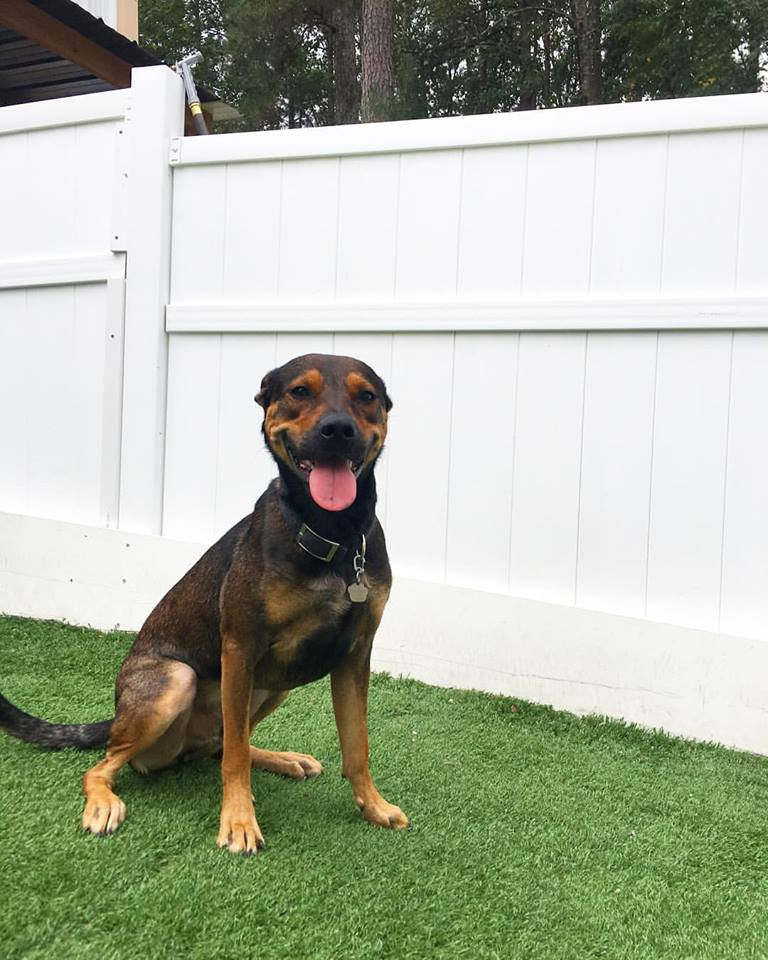

This is believed to be a dog. Its predicted breed is: 
(1, 7, 7, 2048)
(1, 133)
German_pinscher


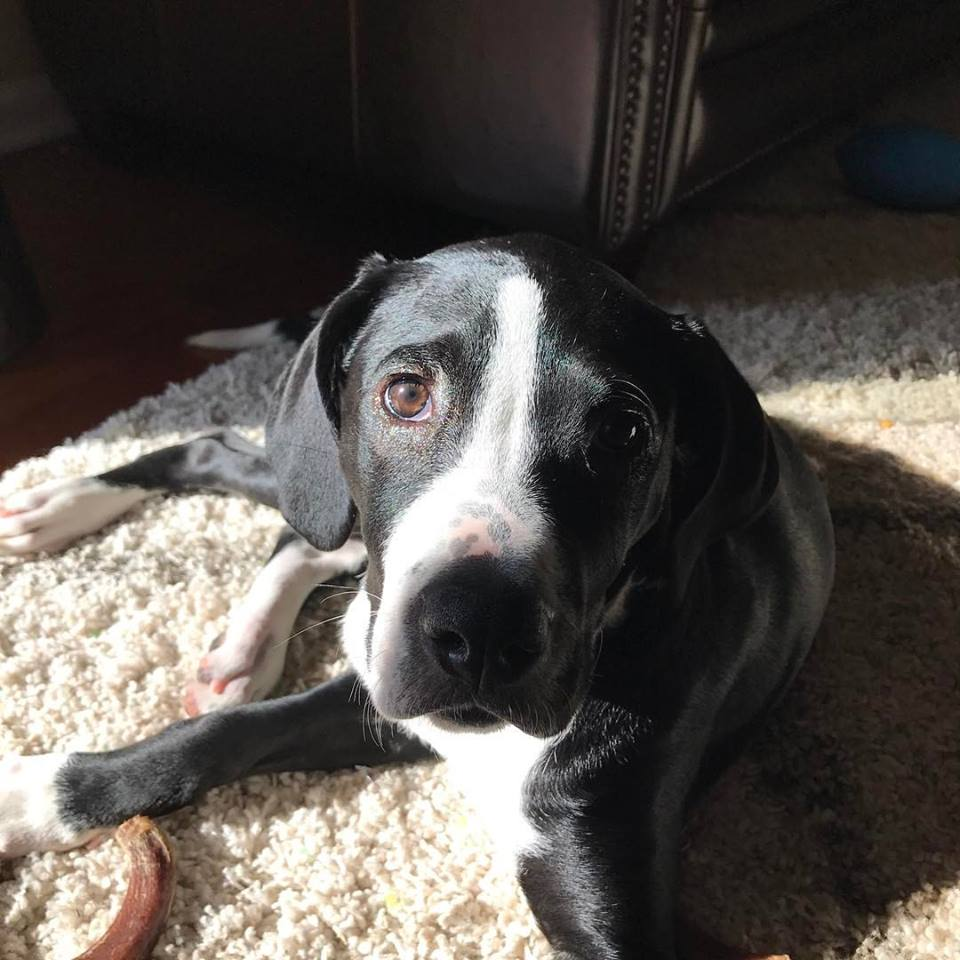

This is believed to be a dog. Its predicted breed is: 
(1, 7, 7, 2048)
(1, 133)
Bluetick_coonhound


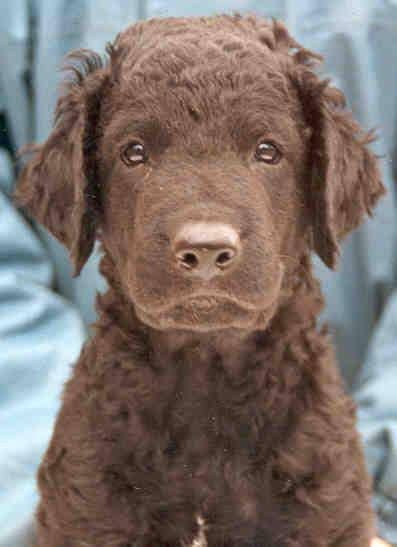

This is believed to be a dog. Its predicted breed is: 
(1, 7, 7, 2048)
(1, 133)
Curly-coated_retriever


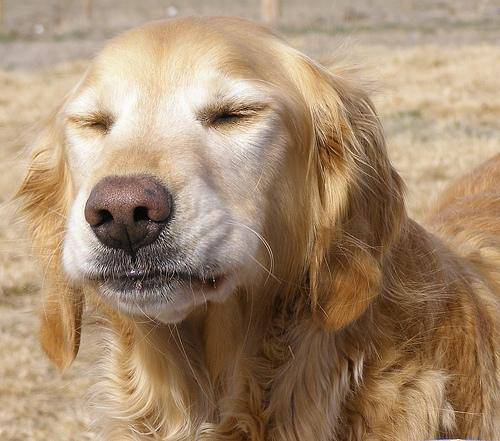

This is believed to be a dog. Its predicted breed is: 
(1, 7, 7, 2048)
(1, 133)
Golden_retriever


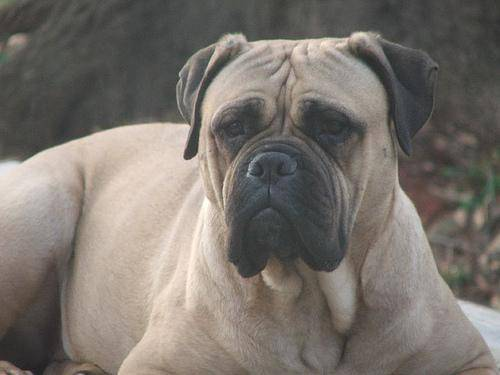

This is believed to be a dog. Its predicted breed is: 
(1, 7, 7, 2048)
(1, 133)
Bullmastiff


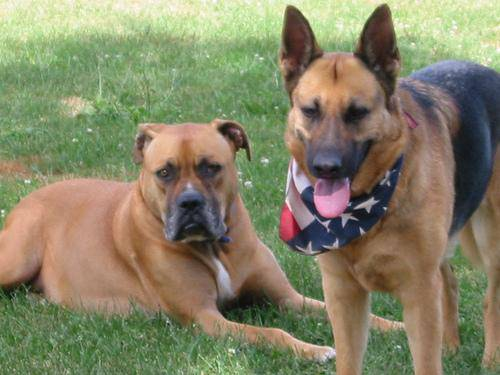

This is believed to be a dog. Its predicted breed is: 
(1, 7, 7, 2048)
(1, 133)
Chinese_shar-pei


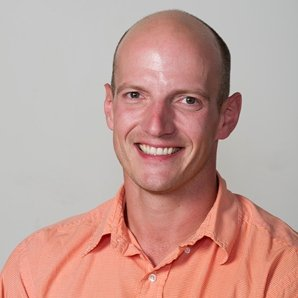

This is believed to be a human. Its predicted breed is: 
(1, 7, 7, 2048)
(1, 133)
Petit_basset_griffon_vendeen


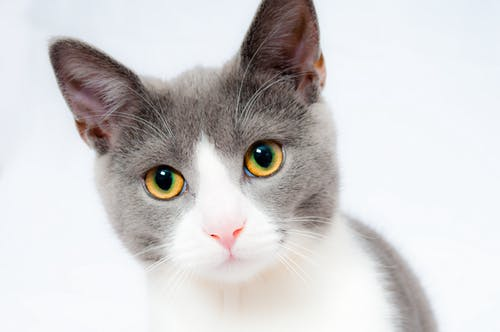

Could not identify a human or dog in the chosen image. Try again.
None


In [90]:
#testing the algorithm against a handful of new images.
print(dog_breed_algorithm('C:/Users/jseymour/Desktop/Pics/Gunner.jpg'))
print(dog_breed_algorithm('C:/Users/jseymour/Desktop/Pics/Riley_best_pic.jpg'))
print(dog_breed_algorithm('C:/Users/jseymour/Desktop/Pics/Curly_lab.jpg'))
print(dog_breed_algorithm('C:/Users/jseymour/Desktop/Pics/Golden_Retriever.jpg'))
print(dog_breed_algorithm('C:/Users/jseymour/Desktop/Pics/Mastif.jpg'))
print(dog_breed_algorithm('C:/Users/jseymour/Desktop/Pics/double_dog.jpg'))
print(dog_breed_algorithm('C:/Users/jseymour/Desktop/Pics/Josh.jpg'))
print(dog_breed_algorithm('C:/Users/jseymour/Desktop/Pics/cat.jpeg'))

In [91]:
import sklearn  #allows us to access the classsication report feature
from sklearn.metrics import classification_report   #allows us to see the accuracy of the model against each classification

In [92]:
#create the classification report, which includes the precision, recall, f1-score and support values
Y_test = np.argmax(test_targets, axis=1) 
y_pred = Xception_model.predict_classes(test_Xception)
report = classification_report(Y_test, y_pred, output_dict=True)

In [93]:
#move the classification report into a df so we can export to a csv to load to postgres Db dog attribure table
recallDf = pd.DataFrame(report).transpose()  
recallDf.to_csv('exploration/recallDf.csv')  

In [94]:
#save off the keras model to be called from Flask
Xception_model.save('saved_models/dogClassification_test.h5')

In [8]:
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [11]:
# Recreate the exact same model purely from the file
classifier = keras.models.load_model('models/dogClassification.h5')

In [15]:
from keras.preprocessing import image
import numpy as np
from extract_bottleneck_features import *

img_path=r'C:\Users\tmason\Desktop\Photos\Franklin\IMG_0001.JPG'

# recreating the path_to_tensor function
# loads RGB image as PIL.Image.Image type
img = image.load_img(img_path, target_size=(224,224))
# convert PIL.Image.Image type to 3D tensor with shape (224, 224)
x = image.img_to_array(img)
# convert 3D tensor to 4D tensor with shape (1,224, 224, 3) and return 4D tensor
test_image = np.expand_dims(x, axis=0)
test_image = extract_Xception(test_image)
predicted_vector = classifier.predict(test_image)
result = dog_names[np.argmax(predicted_vector)]
print(result)

Finnish_spitz


## Predict Top 5

In [38]:
import heapq

top5=heapq.nlargest(5, range(len(predicted_vector[0])), key=predicted_vector[0].__getitem__)
print(top5)

[66, 111, 85, 59, 49]


In [39]:
result1=dog_names[top5[0]]
result2=dog_names[top5[1]]
result3=dog_names[top5[2]]
result4=dog_names[top5[3]]
result5=dog_names[top5[4]]
print(result1)
print(result2)
print(result3)
print(result4)
print(result5)

Finnish_spitz
Nova_scotia_duck_tolling_retriever
Irish_setter
Dogue_de_bordeaux
Chinese_shar-pei


In [43]:
percent1=predicted_vector[0][top5[0]]*100
percent2=predicted_vector[0][top5[1]]*100
percent3=predicted_vector[0][top5[2]]*100
percent4=predicted_vector[0][top5[3]]*100
percent5=predicted_vector[0][top5[4]]*100
print(percent1)
print(percent2)
print(percent3)
print(percent4)
print(percent5)

80.58860898017883
9.437567740678787
3.2485663890838623
3.1626425683498383
1.6357921063899994
